# Pearson Correlation of New Translocation Data

In this notebook I want to compare the new translocation data against our old w1118 data. The new data includes a w1118 sample (testis4) which should be highly comparable with the old data.

In [3]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.io import cellranger_counts
from larval_gonad.normalization import tpm

In [16]:
# quick helper function for importing
def sum_filtered_matrix(fname, sample):
    raw = cellranger_counts(fname)
    return pd.DataFrame(data=raw.matrix.sum(axis=1), index=raw.gene_ids, columns=[sample])

In [22]:
# make raw read count matrix
df = pd.concat([
    sum_filtered_matrix('../output/scrnaseq-wf/scrnaseq_samples/testis1_force/outs/filtered_gene_bc_matrices_h5.h5', 'testis1'),
    sum_filtered_matrix('../output/scrnaseq-wf/scrnaseq_samples/testis2_force/outs/filtered_gene_bc_matrices_h5.h5', 'testis2'),
    sum_filtered_matrix('../output/scrnaseq-wf/scrnaseq_samples/testis3_force/outs/filtered_gene_bc_matrices_h5.h5', 'testis3'),
    sum_filtered_matrix('../output/scrnaseq-wf/scrnaseq_samples/testis4_force/outs/filtered_gene_bc_matrices_h5.h5', 'testis4'),
    sum_filtered_matrix('../output/translocations-wf/scrnaseq_samples/testis_BM5_force/outs/filtered_gene_bc_matrices_h5.h5', 'testis_BM5'),
    sum_filtered_matrix('../output/translocations-wf/scrnaseq_samples/testis_BM21_force/outs/filtered_gene_bc_matrices_h5.h5', 'testis_BM21'),
], sort=True, axis=1)

df.columns.name = 'sample'
df.index.name = 'FBgn'

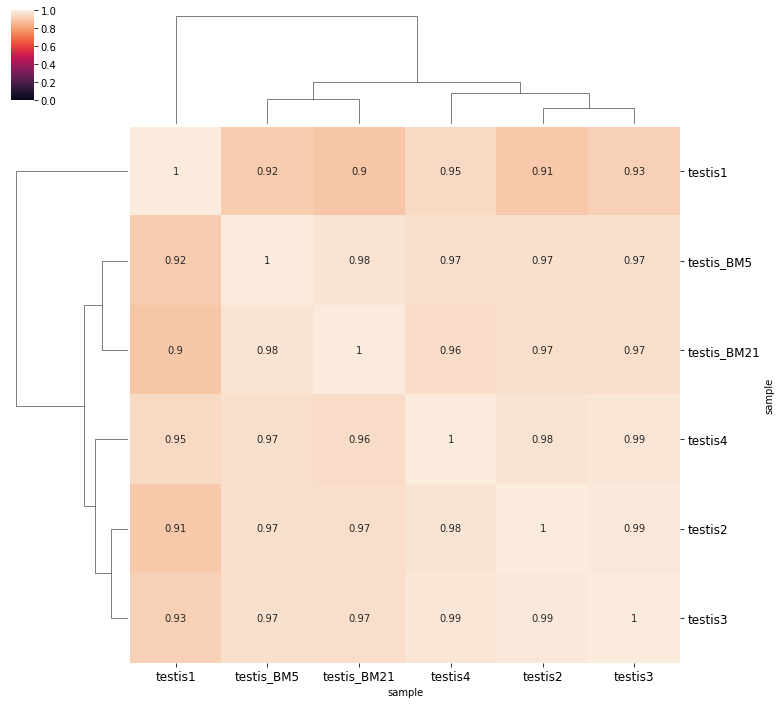

In [121]:
# quick heatmap of spearman's correlation
g = sns.clustermap(df.corr(method='spearman'), vmin=0, vmax=1, annot=True, figsize=(12, 12))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=12);
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=12);

In [122]:
# TPM normalize
gene_lens = pd.read_csv('../output/gene_ts_lengths.tsv', sep='\t', index_col=0).iloc[:, 0]
norm = tpm(df, gene_lens.reindex(df.index)).dropna()
norm.head()

sample,testis1,testis2,testis3,testis4,testis_BM5,testis_BM21
FBgn,,,,,,
FBgn0000003,0.000000,0.012072,0.000000,0.000000,0.000000,0.000000
FBgn0000008,0.126183,0.149321,0.128367,0.091328,0.126227,0.064076
FBgn0000014,15.504531,2.172585,5.951616,10.318963,5.340850,1.402583
FBgn0000015,30.694936,1.908048,3.487089,8.343498,5.737774,0.855743
FBgn0000017,25.912214,4.830630,9.877843,9.852702,12.405662,11.105276


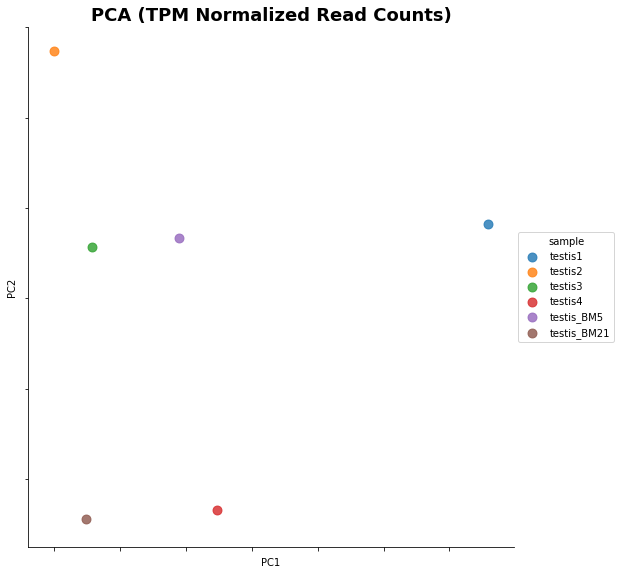

In [123]:
# quick PCA 
pca = PCA(n_components=2)
pca.fit(norm.T)
pcs = pd.DataFrame(data=pca.transform(norm.T), index=norm.T.index, columns=['PC1', 'PC2'])
ax = sns.lmplot('PC1', 'PC2', data=pcs.reset_index(), hue='sample', fit_reg=False, size=8, scatter_kws=dict(s=80))
ax.set_xticklabels([]);
ax.set_yticklabels([]);
plt.title('PCA (TPM Normalized Read Counts)', fontsize=18, fontweight='bold');